In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)
# LENA already has CVC

def group_data(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    data = data.groupby('recording_filename').agg({
        '5s_CTC': np.sum,
        'voc_dur_chi': np.sum,
        'voc_chi': np.sum,
        'wc_adu': np.sum,
        'CVC': np.sum,
        'group_id': 'first',
        'child_id': 'first'
    }).reset_index()
    return data

aclew_measures = group_data(aclew_measures)
lena_measures = group_data(lena_measures)
human_measures = group_data(human_measures)


/tmp/ipykernel_21024/3906960463.py:35: FutureWarning: The provided callable <function sum at 0x7a2f75ba2ef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_21024/3906960463.py:35: FutureWarning: The provided callable <function sum at 0x7a2f75ba2ef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_21024/3906960463.py:35: FutureWarning: The provided callable <function sum at 0x7a2f75ba2ef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykerne

52 132
60 127
12 13
84 201
64 85
23 57
80 141
34 66
34 70
21 104
160 220
151 274
79 99
62 89
12 47
76 39
62 190
3 0
8 20
7 28
47 65
51 105
34 44
58 45
13 28
20 48
71 118
31 69
6 18
44 48
139 220
83 121
21 29
63 147
66 199
31 60
13 36
110 169
22 61
26 67
42 116
5 10
0 11
35 72
93 153
37 107
27 45
109 187
42 103
65 156


In [24]:
from scipy import stats

def compute_pearson(x, y):
    """ Compute Pearson correlation coefficient """
    r, _ = stats.pearsonr(x, y)
    return r

def compute_group_pearson(x, y, groups):
    out = {}
    for group in np.unique(groups):
        mask = groups == group
        x_group = x[mask]
        y_group = y[mask]
        r, _ = stats.pearsonr(x_group, y_group)
        out[group] = r
    return out
    
def compute_me(x, y):
    """ Compute mean error """
    me_list = (x-y).values
    return me_list

def compute_mpe(x, y):
    """ Compute mean error """
    errors = np.zeros_like(x, dtype=float)
    # Case 1: y != 0 - standard MPE calculation
    mask_nonzero = (y != 0)
    errors[mask_nonzero] = (x[mask_nonzero] - y[mask_nonzero]) / y[mask_nonzero]
    # Case 2: y = 0 and x != 0 -> error = 1
    mask_zero_error = (y == 0) & (x != 0)
    errors[mask_zero_error] = 1
    # Case 3: y = 0 and x = 0 -> error = 0 is already handled by initialization
    return 100*errors


columns = ['group_id', '5s_CTC', 'voc_dur_chi', 'voc_chi', 'wc_adu', 'CVC']
lena_scores, aclew_scores = {}, {}
print("Computing on %d chunks." % len(human_measures))
for col in columns:
    if col == 'group_id':
        lena_scores[col] = lena_measures[col].values
        aclew_scores[col] = aclew_measures[col].values
        continue
        
    if col == 'voc_dur_chi':
        lena_measures[col] /= 1000
        aclew_measures[col] /= 1000
        human_measures[col] /= 1000

    recording_ids = human_measures['recording_filename'].values
    groups =  human_measures['group_id'].values
    # Compute LENA
    lena_pearson_r = compute_pearson(lena_measures[col], human_measures[col])
    lena_group_pearson_r = compute_group_pearson(lena_measures[col], human_measures[col], groups)
    lena_me_list = compute_me(lena_measures[col], human_measures[col])
    lena_mpe_list = compute_mpe(lena_measures[col], human_measures[col])

    # Compute ACLEW
    aclew_pearson_r = compute_pearson(aclew_measures[col], human_measures[col])
    aclew_group_pearson_r = compute_group_pearson(aclew_measures[col], human_measures[col], groups)
    aclew_me_list = compute_me(aclew_measures[col], human_measures[col])
    aclew_mpe_list = compute_mpe(aclew_measures[col], human_measures[col])
    lena_scores[col] = {
        'me_list': lena_me_list,

        'mpe_list': lena_mpe_list,

        'pearson_r': lena_pearson_r,
        'group_pearson_r': lena_group_pearson_r,
        'recording_id': recording_ids
        }
    aclew_scores[col] = {
        'me_list': aclew_me_list,

        'mpe_list': aclew_mpe_list,

        'pearson_r': aclew_pearson_r,
        'group_pearson_r': aclew_group_pearson_r,
        'recording_id': recording_ids
        }
    

Computing on 50 chunks.


In [14]:
print(aclew_scores['5s_CTC']['mpe_list'])
print(aclew_scores['5s_CTC']['recording_id'])

[ 25.          -2.36220472 276.92307692 -15.92039801  32.94117647
  17.54385965  -4.96453901  19.6969697   54.28571429 -30.76923077
  -3.63636364 -13.50364964  51.51515152  13.48314607  -2.12765957
 207.69230769   2.63157895 100.          70.          60.71428571
  35.38461538  10.47619048 122.72727273  55.55555556  46.42857143
   8.33333333  -7.62711864  27.53623188   5.55555556  43.75
  -7.27272727   4.95867769 113.79310345   2.72108844 -27.63819095
  13.33333333 -13.88888889  17.75147929  -9.83606557  40.29850746
   2.5862069   60.           9.09090909   2.77777778 -11.11111111
 -42.99065421  13.33333333  -6.4171123  -43.68932039   9.61538462]
['20180530_181655_022873.wav' '20180808_110630_024879.wav'
 '20180808_111213_024881.wav' '20180809_181624_025481.wav'
 '20180906_131431_024882.wav' '20180906_133202_022870.wav'
 '20181218_132113_024879.wav' '20190307_091344_022872.wav'
 '20190307_114201_025481.wav' '20190618_135122_024883.wav'
 '20190819_210318_025481_2.wav' '20190828_145547_0

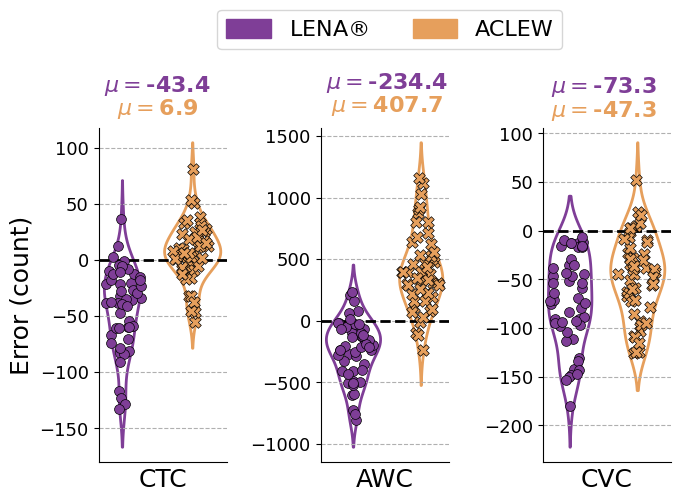

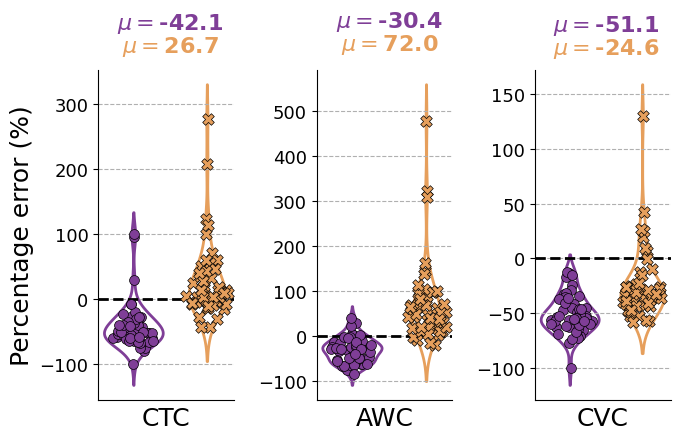

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

cm = 1/2.54
lena_color = '#7F3E97'
aclew_color = '#E69F5C'
measure_name = {
    '5s_CTC': 'CTC',
    '1s_CTC': 'CTC (1s)',
    'voc_dur_chi': 'Duration of the key child vocalizations',
    'voc_chi': 'Number of key child vocalizations',
    'wc_adu': 'AWC',
    'CVC': 'CVC'
}

metric_name = {
    'pearson': "Pearson's R",
    'mpe': "Percentage error (%)",
    'me': "Error"
}

def plot_measures_sequence(lena_scores, aclew_scores, measures, metric='pearson'):
    """
    Plot a sequence of subplots, one for each measure, showing a single metric.
    """
    n_measures = len(measures)
    fig_width = 6 * n_measures
    fig, axes = plt.subplots(1, n_measures, figsize=(fig_width*cm, 12*cm))
    alpha=1
    if n_measures == 1:
        axes = [axes]
    
    for i, (ax, measure) in enumerate(zip(axes, measures)):
        lena_errors = lena_scores[measure][f'{metric}_list']
        aclew_errors = aclew_scores[measure][f'{metric}_list']
        
        plot_data = pd.DataFrame({
            'Algorithm': ['LENA'] * len(lena_errors) + ['ACLEW'] * len(aclew_errors),
            'Error': list(lena_errors) + list(aclew_errors)
        })
        
        # Create violin plot with points inside
        violin_parts = sns.violinplot(data=plot_data, x='Algorithm', y='Error',
                                    ax=ax, color='white', inner=None,
                                    linewidth=2)
        
        # Modify violin colors
        for pc in violin_parts.collections:
            pc.set_facecolor('none')
            pc.set_edgecolor(lena_color if pc == violin_parts.collections[0] else aclew_color)
        
        # Calculate kernel density for point placement
        kde_lena = stats.gaussian_kde(lena_errors)
        kde_aclew = stats.gaussian_kde(aclew_errors)
        
        # Function to calculate x position based on density
        def get_x_position(y_val, kde, center_x, max_width=0.3):
            density = kde(y_val)[0]
            max_density = kde(kde.dataset).max()
            width = max_width * (density / max_density)
            return center_x + np.random.uniform(-width, width)
        
        # Plot LENA points
        for y_val in lena_errors:
            x_pos = get_x_position(y_val, kde_lena, 0)
            ax.scatter(x_pos, y_val, color=lena_color, edgecolor='black',
                      s=50, zorder=3, linewidth=0.5, alpha=alpha)
        
        # Plot ACLEW points
        for y_val in aclew_errors:
            x_pos = get_x_position(y_val, kde_aclew, 1)
            ax.scatter(x_pos, y_val, color=aclew_color, edgecolor='black',
                       s=70, marker='X', zorder=3, linewidth=0.5, alpha=alpha)
        
        # Add mean values
        ymin, ymax = ax.get_ylim()
        lena_avg = np.mean(lena_errors)
        aclew_avg = np.mean(aclew_errors)
        
        yshift = .07*(ymax-ymin)
        ax.text(0.5, 1.05*ymax+yshift, r'$\mu = $' + f'{lena_avg:.1f}',
                ha='center', va='bottom', color=lena_color, weight='bold')
        ax.text(0.5, 1.05*ymax, r'$\mu = $' + f'{aclew_avg:.1f}',
                ha='center', va='bottom', color=aclew_color, weight='bold')
        
        # Set labels and styling
        if i == 0:
            ylabel = metric_name[metric]
            if metric == 'me':
                ylabel += ' (s)' if measure == 'voc_dur_chi' else ' (count)'
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
            
        ax.set_xlabel(measure_name[measure], fontsize=18)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.grid(True, linestyle='--', alpha=alpha, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=2)
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=lena_color),
              plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = [r'LENA$\circledR$', r'ACLEW']
    if metric == 'me':
        fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.57, 1.03), loc='center')
    
    plt.tight_layout()
    return fig, axes

measures_to_compare = ['5s_CTC', 'wc_adu', 'CVC']
 
# For ME comparison
fig, axes = plot_measures_sequence(lena_scores, aclew_scores, measures_to_compare, 'me')
plt.savefig('/home/engaclew/neurogen/figures/30mn/measures_me.png', dpi=300, bbox_inches='tight')
plt.show()

# For MPE comparison
fig, axes = plot_measures_sequence(lena_scores, aclew_scores, measures_to_compare, 'mpe')
plt.savefig('/home/engaclew/neurogen/figures/30mn/measures_mpe.png', dpi=300, bbox_inches='tight')
plt.show()

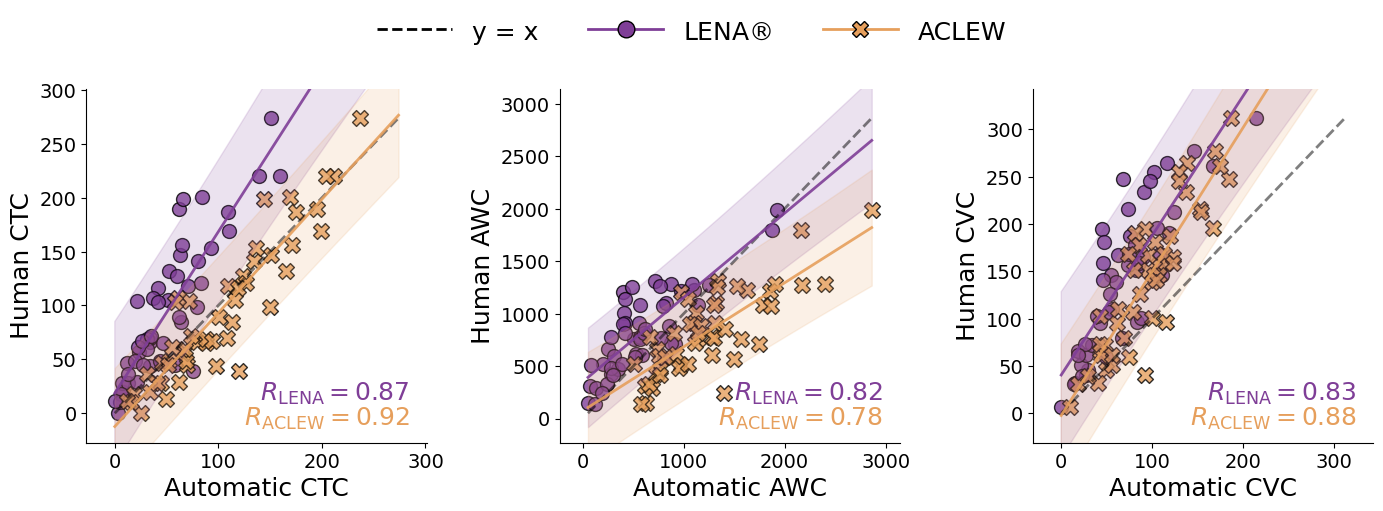

In [26]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 18, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 6, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize':14, 'ytick.labelsize':14, 'axes.labelsize': 18})

cm = 1/2.54
lena_color = '#7F3E97'
aclew_color = '#E69F5C'

def add_regression_plot(ax, lena_x, aclew_x, human_y):
    """Add scatter plots and regression lines with confidence intervals.
    Args:
        lena_x, aclew_x: predictor variables (automatic measures)
        human_y: target variable to predict (human measures)
    """
    # Get common range for both x and y
    min_val = min(lena_x.min(), aclew_x.min(), human_y.min())
    max_val = max(lena_x.max(), aclew_x.max(), human_y.max())
    
    # Create range for regression lines
    plot_range = np.linspace(min_val, max_val, 100)
    
    # Add y=x line first
    ax.plot(plot_range, plot_range, 'k--', alpha=0.5, label='y = x')
    
    def calc_regression(x, y, color):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        y_pred = slope * plot_range + intercept
        
        # Calculate prediction interval
        y_hat = slope * x + intercept
        mse = np.sum((y - y_hat) ** 2) / (len(x) - 2)
        x_mean = np.mean(x)
        x_std = np.sum((x - x_mean) ** 2)
        t = stats.t.ppf(0.975, len(x) - 2)
        pi = t * np.sqrt(mse * (1 + 1/len(x) + (plot_range - x_mean)**2 / x_std))
        
        ax.plot(plot_range, y_pred, color=color, alpha=0.9)
        ax.fill_between(plot_range, y_pred - pi, y_pred + pi, color=color, alpha=0.15)
        
        return r_value
    
    # Plot scatter points
    ax.scatter(lena_x, human_y, color=lena_color, alpha=0.8, s=100, edgecolor='black', label='LENA')
    ax.scatter(aclew_x, human_y, color=aclew_color, alpha=0.8, edgecolor='black', marker='X', s=130, label='ACLEW')
    
    # Calculate regression for both datasets
    lena_r = calc_regression(lena_x, human_y, lena_color)
    aclew_r = calc_regression(aclew_x, human_y, aclew_color)
    
    # Set same limits for both axes
    dist = max_val - min_val
    min_val = min_val - 0.1 * dist
    max_val = max_val + 0.1 * dist
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    # Add R values as text annotations
    ax.text(0.95, 0.12, f'$R_{{\\mathrm{{LENA}}}} = {lena_r:.2f}$', 
            transform=ax.transAxes, color=lena_color,
            fontweight='bold', horizontalalignment='right')
    
    ax.text(0.95, 0.05, f'$R_{{\\mathrm{{ACLEW}}}} = {aclew_r:.2f}$', 
            transform=ax.transAxes, color=aclew_color, 
            fontweight='bold', horizontalalignment='right')
    
    return lena_r, aclew_r

def plot_measures_scatter(lena_measures, aclew_measures, human_measures, measures):
    """Plot scatter plots with regression lines for each measure using all data points."""
    n_measures = len(measures)
    fig_width = 12 * n_measures
    fig, axes = plt.subplots(1, n_measures, figsize=(fig_width*cm, 12*cm))
    
    if n_measures == 1:
        axes = [axes]
    
    for i, (ax, measure) in enumerate(zip(axes, measures)):
        # Plot regression and get R values using all data points
        lena_r, aclew_r = add_regression_plot(ax,
                                            lena_measures[measure],  # predictor (x)
                                            aclew_measures[measure], # predictor (x)
                                            human_measures[measure]) # target (y)
        
        ax.set_xlabel(f'Automatic {measure_name[measure]}')  # predictor on x-axis
        ax.set_ylabel(f'Human {measure_name[measure]}')      # target on y-axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    # Create a single legend for all subplots
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', label='y = x', lw=2),  # y=x dashed line
        Line2D([0], [0], color=lena_color, marker='o', label=r'LENA$\circledR$', lw=2, 
               markersize=12, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label=r'ACLEW', lw=2, 
               markersize=12, markerfacecolor=aclew_color, markeredgecolor='black')
    ]
    # Add legend to the figure
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, 1.05), 
               loc='center', frameon=False, handlelength=3)
        
    plt.tight_layout()
    return fig, axes

# Usage example:
measures_to_compare = ['5s_CTC', 'wc_adu', 'CVC']

fig, axes = plot_measures_scatter(lena_measures, aclew_measures, human_measures, 
                                measures_to_compare)
plt.savefig('/home/engaclew/neurogen/figures/30mn/measures_pearson_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

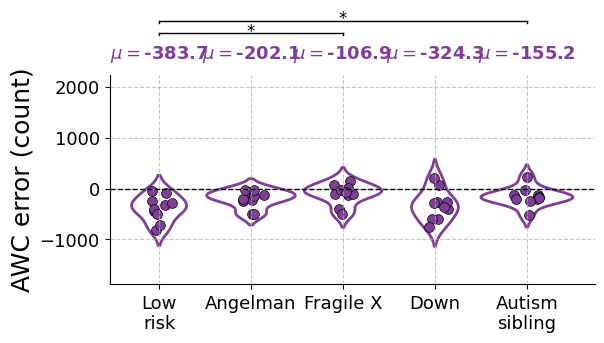

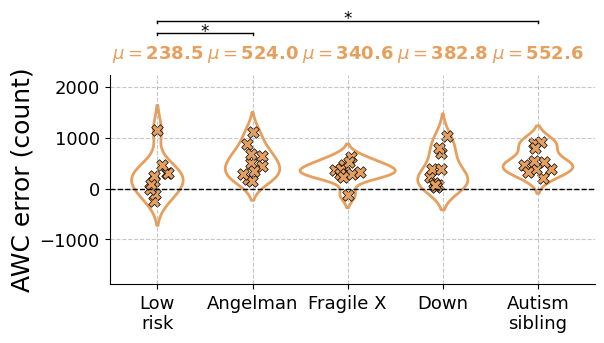

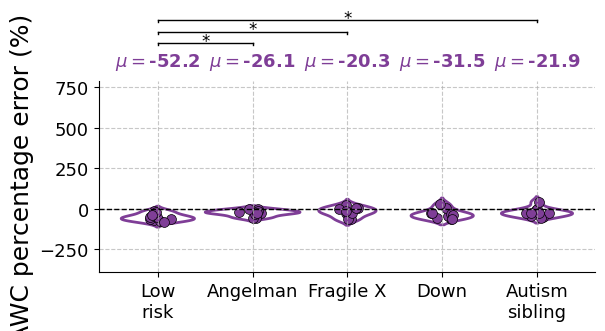

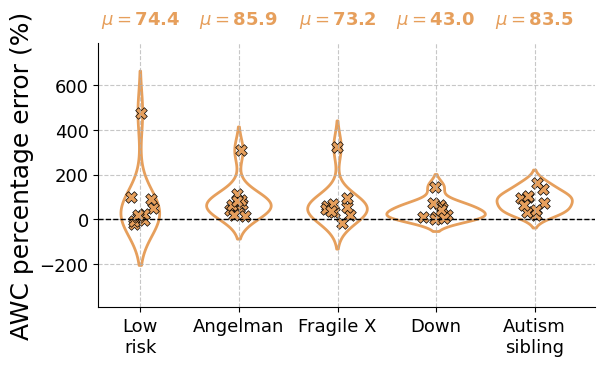

In [13]:
# Group-level performance metrics for CTC, AWC, and CVC measures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patheffects as path_effects
from scipy import stats

matplotlib.rcParams.update({'font.size': 15, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})
def add_group_significance_bars(ax, df, groups, col):
    def get_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        return ''
    
    # Get y-axis range
    ymin, ymax = ax.get_ylim()
    ydist = ymax - ymin
    
    # Calculate relative spacings
    stars_spacing = 0.01 * ydist
    bar_spacing = 0.06 * ydist
    tick_height = 0.01 * ydist
    base_height = ymax + (0.2 * ydist)
    
    # Perform statistical tests against low_risk group
    control_group = 'low_risk'
    control_data = df[df['group_id'] == control_group][col]
    
    sig_count = 0
    has_sig_res = False
    
    # Compare each group against control
    for i, group in enumerate(groups[1:], 1):  # Skip control group
        group_data = df[df['group_id'] == group][col]
        if len(group_data) == 0:  # Skip if no data for this group
            continue
            
        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(
            control_data, 
            group_data,
            alternative='two-sided'
        )
        
        # Add significance bars if result is significant
        stars = get_stars(p_value)
        if stars:
            has_sig_res = True
            current_height = base_height + (sig_count * bar_spacing)
            sig_count += 1
            
            # Draw the bar and ticks
            ax.plot([0, i], [current_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            ax.plot([0, 0], [current_height - tick_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            ax.plot([i, i], [current_height - tick_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            
            # Add stars
            ax.text((0 + i) / 2, current_height + stars_spacing,
                   stars, ha='center', va='center', 
                   fontsize=12, clip_on=False)
    
    ax.set_ylim(ymin, ymax)

def plot_metric_by_groups(scores, algorithm='LENA', measure='5s_CTC', metric='me', y_limits=None):
    # Define label mapping with desired order
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    # Use ordered list of groups
    groups = list(label_name.keys())
    
    def get_x_position(y_val, kde, center_x, max_width=0.15):
        density = kde(y_val)[0]
        max_density = kde(kde.dataset).max()
        width = max_width * (density / max_density)
        return center_x + np.random.uniform(-width, width)
    
    # Style parameters
    color = '#7F3E97' if algorithm == 'LENA' else '#E69F5C'
    marker = 'o' if algorithm == 'LENA' else 'X'
    marker_size = 50 if algorithm == 'LENA' else 70
    cm = 1/2.54
    width = 1
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(16*cm, 10*cm))
    
    if metric in ['me', 'mpe']:
        # Create plot data
        plot_data = []
        for group_id in groups:
            mask = scores['group_id'] == group_id
            values = scores[measure][f'{metric}_list'][mask]
            plot_data.extend([{
                'group_id': group_id,
                'group_label': label_name[group_id],
                'error': val
            } for val in values])
        
        df = pd.DataFrame(plot_data)
        
        # Create violin plot
        violin_parts = sns.violinplot(data=df, x='group_label', y='error',
                                    ax=ax, color='white', width=width,
                                    inner=None, linewidth=2)
        
        for pc in violin_parts.collections:
            pc.set_facecolor('none')
            pc.set_edgecolor(color)
        
        # Add scatter points
        for i, group_id in enumerate(groups):
            group_data = df[df['group_id'] == group_id]['error']
            if len(group_data) > 0:
                kde = stats.gaussian_kde(group_data)
                for y_val in group_data:
                    x_pos = i + get_x_position(y_val, kde, 0)
                    ax.scatter(x_pos, y_val, 
                             color=color,
                             edgecolor='black',
                             s=marker_size,
                             marker=marker,
                             linewidth=0.5)

                if y_limits is not None:
                    ax.set_ylim(y_limits)
                    
                # Add mean value
                mean_val = group_data.mean()
                ymin, ymax = ax.get_ylim()
                ax.text(i, ymax + 0.05*(ymax - ymin), 
                       r'$\mu = $' + f'{mean_val:.1f}',
                       ha='center', va='bottom', fontsize=13, 
                       color=color, weight='bold')
        
        # Add styling
        metric_labels = {
            'me': 'error',
            'mpe': 'percentage error (%)',
        }
        measure_labels = {
            '5s_CTC': 'CTC',
            'wc_adu': 'AWC',
            'CVC': 'CVC'
        }
        
        ylabel = f'{measure_labels[measure]} {metric_labels[metric]}'
        if metric == 'me' and measure == 'voc_dur_chi':
            ylabel += ' (s)'
        elif metric == 'me':
            ylabel += ' (count)'
        
        ax.axhline(0, color='black', linestyle='--', linewidth=1, zorder=2)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('')
        ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add significance bars and adjust layout
        add_group_significance_bars(ax, df, groups, 'error')
        plt.tight_layout()
    
    return fig, ax

#mesures = ['CVC', '5s_CTC', 'wc_adu']
measures = ['wc_adu']
for measure in measures:
    for metric in ['me', 'mpe']:
        lena_data = [val for mask in (lena_scores['group_id'] == group_id for group_id in groups)
                    for val in lena_scores[measure][f'{metric}_list'][mask]]
        aclew_data = [val for mask in (aclew_scores['group_id'] == group_id for group_id in groups)
                     for val in aclew_scores[measure][f'{metric}_list'][mask]]
        
        all_data = lena_data + aclew_data
        y_min = min(all_data)
        y_max = max(all_data)
        # Add some padding (e.g., 5%)
        padding = (y_max - y_min) * 0.55
        y_limits = (y_min - padding, y_max + padding)
        
        fig, ax = plot_metric_by_groups(lena_scores, algorithm='LENA', measure=measure, metric=metric, y_limits=y_limits)
        plt.savefig(f'/home/engaclew/neurogen/figures/30mn_group/group_{metric}_lena_{measure}.png', dpi=300)
        plt.show()

        fig, ax = plot_metric_by_groups(aclew_scores, algorithm='ACLEW', measure=measure, metric=metric, y_limits=y_limits)
        plt.savefig(f'/home/engaclew/neurogen/figures/30mn_group/group_{metric}_aclew_{measure}.png', dpi=300)
        plt.show()
#fig, ax = plot_metric_by_groups(lena_scores, algorithm='LENA', measure='wc_adu', metric='mpe')
#plt.show()

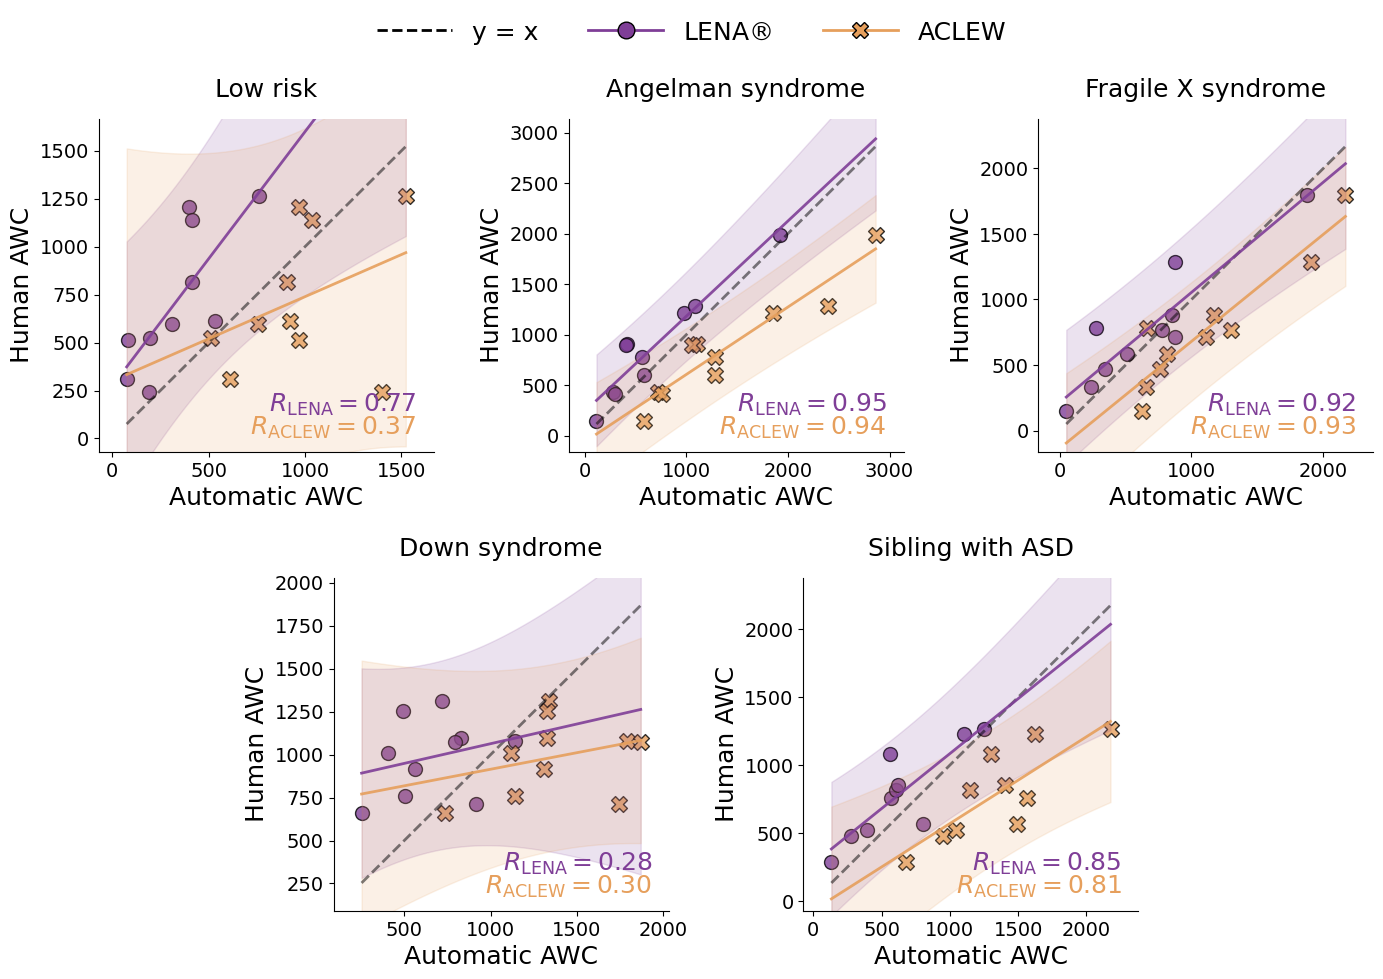

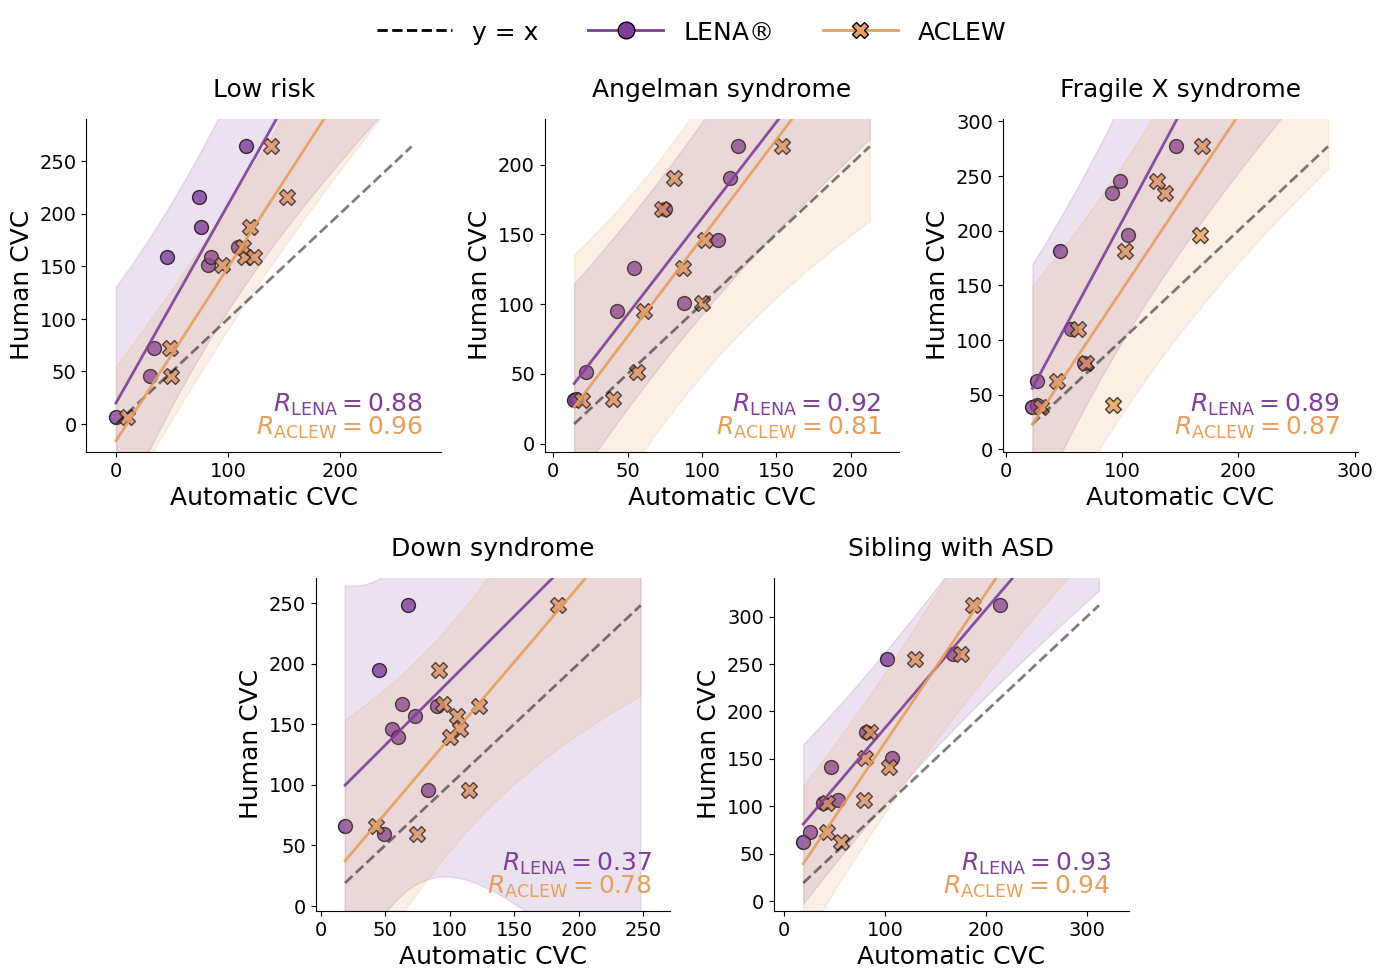

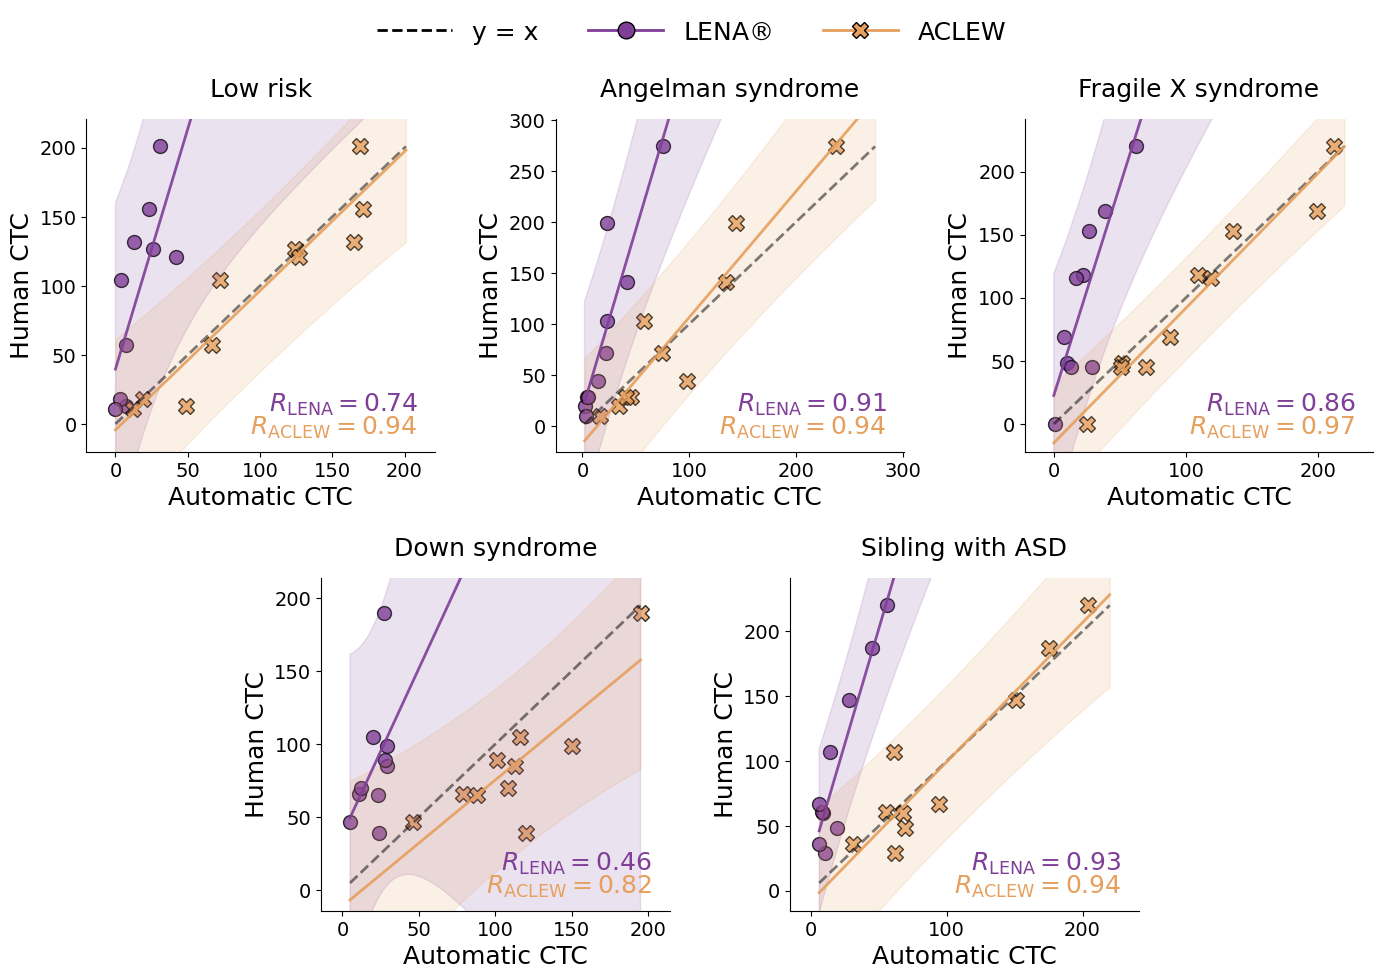

In [7]:
def plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, measure):
    """Plot scatter plots with regression lines for a single measure across groups.
    First row has 3 plots, second row has 2 centered plots."""
    
    # Define group labels (also defines the order)
    group_labels = {
        'low_risk': 'Low risk',
        'angelman_syndrome': 'Angelman syndrome',
        'fragile_x_syndrome': 'Fragile X syndrome',
        'down_syndrome': 'Down syndrome',
        'autism_sibling': 'Sibling with ASD'
    }
    
    # Create figure with irregular grid
    fig = plt.figure(figsize=(36*cm, 24*cm))
    gs = fig.add_gridspec(2, 6, height_ratios=[1, 1])
    
    # Create axes - 3 on top, 2 centered on bottom
    axes = []
    # Top row - 3 plots
    for i in range(3):
        ax = fig.add_subplot(gs[0, i*2:i*2+2])
        axes.append(ax)
    # Bottom row - 2 plots centered
    for i in range(2):
        ax = fig.add_subplot(gs[1, i*2+1:i*2+3])
        axes.append(ax)
        
    for ax, group_key in zip(axes, group_labels.keys()):
        # Filter data for this group
        group_mask = human_measures['group_id'] == group_key
        lena_group = lena_measures[group_mask]
        aclew_group = aclew_measures[group_mask]
        human_group = human_measures[group_mask]
        
        # Plot regression and get R values
        lena_r, aclew_r = add_regression_plot(ax,
                                            lena_group[measure],
                                            aclew_group[measure],
                                            human_group[measure])
        
        # Set labels
        ax.set_xlabel(f'Automatic {measure_name[measure]}')
        ax.set_ylabel(f'Human {measure_name[measure]}')
        
        # Add group label
        ax.text(0.5, 1.05, group_labels[group_key],
               transform=ax.transAxes,
               ha='center',
               va='bottom')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', label='y = x', lw=2),
        Line2D([0], [0], color=lena_color, marker='o', label=r'LENA$\circledR$', lw=2,
               markersize=12, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label=r'ACLEW', lw=2,
               markersize=12, markerfacecolor=aclew_color, markeredgecolor='black')
    ]

    # Add legend to the figure
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, 1.02),
               loc='center', frameon=False, handlelength=3)
    
    plt.tight_layout()
    return fig, axes

# Usage
measure_to_plot = 'wc_adu'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_pearson_lena_vtc_awc.png', dpi=300)
plt.show()

measure_to_plot = 'CVC'  # or 'wc_adu' or 'CVC'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_pearson_lena_vtc_cvc.png', dpi=300)
plt.show()

measure_to_plot = '5s_CTC'  # or 'wc_adu' or 'CVC'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_pearson_lena_vtc_ctc.png', dpi=300)
plt.show()

In [91]:
# Cumulated duration per group
mean_voc_dur_human = human_measures.groupby('group_id')['voc_dur_chi'].mean()
print(mean_voc_dur_human)
mean_voc_dur_aclew = aclew_measures.groupby('group_id')['voc_dur_chi'].mean()
print(mean_voc_dur_aclew)
mean_voc_dur_lena = lena_measures.groupby('group_id')['voc_dur_chi'].mean()
print(mean_voc_dur_lena)

group_id
angelman_syndrome     0.076710
autism_sibling        0.162581
down_syndrome         0.106491
fragile_x_syndrome    0.114033
low_risk              0.157015
Name: voc_dur_chi, dtype: float64
group_id
angelman_syndrome     0.103386
autism_sibling        0.232370
down_syndrome         0.158932
fragile_x_syndrome    0.157318
low_risk              0.205453
Name: voc_dur_chi, dtype: float64
group_id
angelman_syndrome     0.049937
autism_sibling        0.140157
down_syndrome         0.081858
fragile_x_syndrome    0.089925
low_risk              0.127758
Name: voc_dur_chi, dtype: float64


In [8]:
lena_scores

{'group_id': array(['low_risk', 'low_risk', 'down_syndrome', 'angelman_syndrome',
        'down_syndrome', 'low_risk', 'angelman_syndrome', 'down_syndrome',
        'angelman_syndrome', 'angelman_syndrome', 'down_syndrome',
        'down_syndrome', 'fragile_x_syndrome', 'angelman_syndrome',
        'fragile_x_syndrome', 'fragile_x_syndrome', 'low_risk', 'low_risk',
        'autism_sibling', 'fragile_x_syndrome', 'fragile_x_syndrome',
        'angelman_syndrome', 'angelman_syndrome', 'autism_sibling',
        'fragile_x_syndrome', 'autism_sibling'], dtype=object),
 '5s_CTC': {'me_list': array([  -6, -170,  -56,  -99,  -55, -100, -147, -163,  -18,  -24,  -42,
          -85,  -16,  -23,  -38,  -96,  -15,  -79,  -51, -130,  -99,   -7,
          -50,  -93,  -32, -142]),
  'mpe_list': array([-46.15384615, -84.57711443, -65.88235294, -70.21276596,
         -83.33333333, -96.15384615, -73.13432836, -85.78947368,
         -90.        , -85.71428571, -64.61538462, -80.95238095,
         -35.5555

In [10]:
human_measures

,recording_filename,5s_CTC,voc_dur_chi,voc_chi,wc_adu,CVC,group_id,child_id
0,20180808_111213_024881.wav,13,109.716,152,309,151,low_risk,2761
1,20180809_181624_025481.wav,201,282.531,287,1139,264,low_risk,2781
2,20180906_131431_024882.wav,85,103.954,157,1096,157,down_syndrome,3591
3,20181218_132113_024879.wav,141,81.592,147,1214,146,angelman_syndrome,3131
4,20190307_091344_022872.wav,66,166.508,213,659,195,down_syndrome,3951
5,20190618_135122_024883.wav,104,196.250,100,598,46,low_risk,5011
6,20190828_145547_024884_2.wav,201,141.494,158,1412,157,angelman_syndrome,5061
7,20201104_094551_024882_1.wav,190,116.157,249,914,248,down_syndrome,3871
8,20210127_103244_024879_1.wav,20,42.931,53,781,51,angelman_syndrome,5461
9,20210318_114509_043298.wav,28,16.928,33,910,32,angelman_syndrome,5961
